In [1]:
# Creating the SK Model
import numpy as np
import dgl
import torch


from dgl.data import DGLDataset
import networkx as nx

In [96]:
# This Notebook will create the dataset
# Assume J = 1


N = 50

def complete_graph(N):
    g = dgl.graph(([], []), num_nodes = N)
    # Add edges between all pairs of nodes
    for i in range(N):
        for j in range(i+1, N):
            g.add_edges(i, j)
    # Add Reverse Edges
    g.add_edges(g.edges()[1], g.edges()[0])
    return g




class SKDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="synthetic")




    def process(self):
        # Create the Graphs
        self.graphs = []
        self.labels = []

        # Dictionary of Different Combination of J0 and T, with Labels for Phases
        # 0 - Ferromagnetic
        # 1 - Paramagnetic
        # 2 - Spin Glass

        phases = {
            (0.5, 0.5): 2,
            (0.5, 1.5): 1,
            (1.5, 0.5): 0,
            (1.5, 1.5): 1,
            (0.1, 0.1): 2,
            #(0.1, 1.9): 1

        }

        for params, label in phases.items():
            for i in range(100):
                g = complete_graph(N)
                #print(g)

                # Add Temperature
                g.ndata["T"] = torch.full((N,), params[1])
                # Adding Weights
                # Each Weights are iid Gaussian with mean J0/N and variance 1/N
                g.edata['w'] = torch.normal(mean = params[0]/N, std = 1/N, size = (g.number_of_edges(),))

                # all the weights to the nodes as a feature
                g.ndata['a'] = torch.zeros((N, N-1))
                for i in range(N):
                    g.ndata['a'][i] = torch.normal(mean = params[0]/N, std = 1/N, size = (N-1,))
                



                print(g.edata['w'].shape)
                self.graphs.append(g)
                self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)




    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)


dataset = SKDataset()


torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([2450])
torch.Size([

In [42]:
# Batching the Graphs

from dgl.dataloading import GraphDataLoader


#dataset = SKDataset()



In [97]:
# Create a PyTorch DataLoader for constructing batches
data_loader = GraphDataLoader(
    dataset, batch_size=64, shuffle=True, drop_last=False
)


In [98]:
for batch, (batched_graph, labels) in enumerate(data_loader):
    print(batched_graph)
    print(labels)
    break


Graph(num_nodes=3200, num_edges=156800,
      ndata_schemes={'T': Scheme(shape=(), dtype=torch.float32), 'a': Scheme(shape=(49,), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)})
tensor([2, 1, 0, 2, 1, 0, 2, 1, 1, 2, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 0, 2, 0, 2,
        1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 2, 2,
        2, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 2, 1, 2, 2, 0])


In [99]:
for batched_graph, labels in dataset:
    print(batched_graph)
    print(labels)
    break

Graph(num_nodes=50, num_edges=2450,
      ndata_schemes={'T': Scheme(shape=(), dtype=torch.float32), 'a': Scheme(shape=(49,), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)})
tensor(2)


In [100]:
from dgl.dataloading import GraphDataLoader
dataloader = GraphDataLoader(
    dataset,
    batch_size=1024,
    drop_last=False,
    shuffle=True)

In [101]:
# Ignore This
import dgl.nn.pytorch as dglnn
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, h_feats)
        self.conv2 = dglnn.GraphConv(h_feats, out_feats)
        # Classifier to output 3 classes.
        self.classify = nn.Linear(out_feats, out_feats)

    def forward(self, g, h):
        h = self.conv1(g, h)
        h = torch.relu(h)
        h = self.conv2(g, h)
        h = torch.relu(h)
        with g.local_scope():
            g.edata['a'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'a')
            return self.classify(hg)

In [102]:
# Use This for Classification
import torch.nn.functional as F
import dgl.nn.pytorch as dglnn
import torch.nn as nn


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata['h'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'h')
            return self.classify(hg)

In [80]:
# Training the Model
import torch.nn.functional as F


model = Classifier(49, 20, 3)
opt = torch.optim.Adam(model.parameters())
for epoch in range(200):
    for batch, (batched_graph, labels) in enumerate(data_loader):

        #Find Number of Features:
        print(batched_graph.ndata['a'].shape)
        feats = batched_graph.ndata['a']
        #rint(batched_graph)
        #print("he")
        logits = model(batched_graph, feats)
        #print("ya")
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        print(loss)
        opt.step()
        # Find Accuracy


# Find Accuracy of the Model

correct = 0
total = 0
with torch.no_grad():
    for batch, (batched_graph, labels) in enumerate(data_loader):
        feats = batched_graph.ndata['a']
        logits = model(batched_graph, feats)
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))



torch.Size([3200, 49])
tensor(1.0863, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.1007, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.1061, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0867, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0885, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.1027, grad_fn=<NllLossBackward0>)
torch.Size([800, 49])
tensor(1.0933, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0847, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0945, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0970, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0844, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0907, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0846, grad_fn=<NllLossBackward0>)
torch.Size([800, 49])
tensor(1.1013, grad_fn=<NllLossBackward0>)
torch.Size([3200, 49])
tensor(1.0865, grad_fn=<NllLossBackward0>)
torch.Size([

In [103]:
# Training the Model - Higher Epochs
model = Classifier(49, 20, 3)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
losses = []
for epoch in range(3000):
    for batch, (batched_graph, labels) in enumerate(data_loader):

        #Find Number of Features:
        #print(batched_graph.ndata['a'].shape)
        #print(batched_graph)
        feats = batched_graph.ndata['a']
        #Shape of Batched Data

        #print(batched_graph.batch_size)

        #rint(batched_graph)
        #print("he")
        logits = model(batched_graph, feats)
        #print("ya")
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        print(loss)
        opt.step()
        
        losses.append(loss.item())
        
        # Find Accuracy


# Find Accuracy of the Model

correct = 0
total = 0
with torch.no_grad():
    for batch, (batched_graph, labels) in enumerate(data_loader):
        feats = batched_graph.ndata['a']
        logits = model(batched_graph, feats)
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))



tensor(1.0832, grad_fn=<NllLossBackward0>)
tensor(1.0822, grad_fn=<NllLossBackward0>)
tensor(1.0580, grad_fn=<NllLossBackward0>)
tensor(1.1242, grad_fn=<NllLossBackward0>)
tensor(1.0639, grad_fn=<NllLossBackward0>)
tensor(1.0578, grad_fn=<NllLossBackward0>)
tensor(1.0652, grad_fn=<NllLossBackward0>)
tensor(1.0156, grad_fn=<NllLossBackward0>)
tensor(1.0186, grad_fn=<NllLossBackward0>)
tensor(1.0497, grad_fn=<NllLossBackward0>)
tensor(1.0041, grad_fn=<NllLossBackward0>)
tensor(1.0004, grad_fn=<NllLossBackward0>)
tensor(1.0014, grad_fn=<NllLossBackward0>)
tensor(0.9311, grad_fn=<NllLossBackward0>)
tensor(0.9623, grad_fn=<NllLossBackward0>)
tensor(0.9067, grad_fn=<NllLossBackward0>)
tensor(0.9027, grad_fn=<NllLossBackward0>)
tensor(0.9032, grad_fn=<NllLossBackward0>)
tensor(0.9314, grad_fn=<NllLossBackward0>)
tensor(0.8684, grad_fn=<NllLossBackward0>)
tensor(0.8600, grad_fn=<NllLossBackward0>)
tensor(0.8250, grad_fn=<NllLossBackward0>)
tensor(0.7615, grad_fn=<NllLossBackward0>)
tensor(0.75

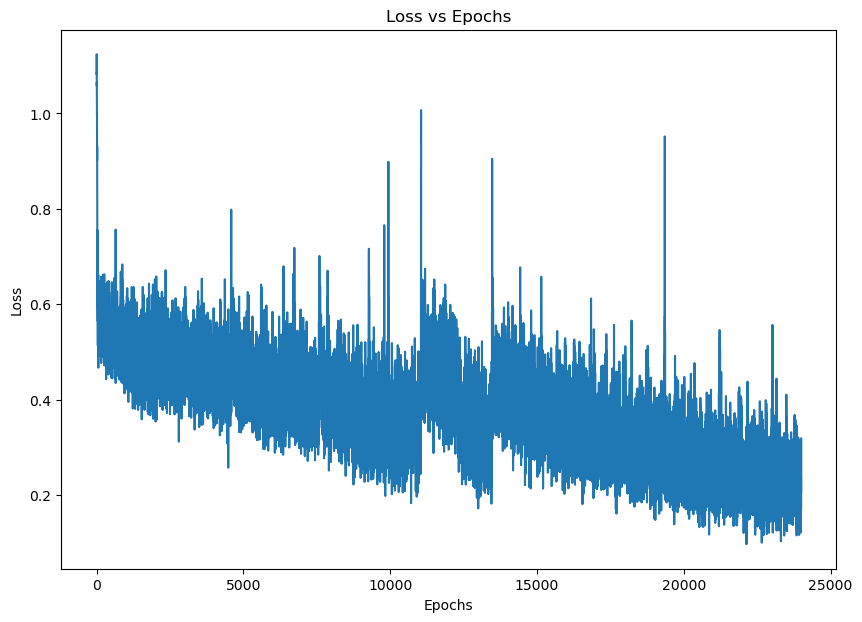

In [105]:
# Plot the Losses

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

